In [1]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

  Activating project at `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN`


   Resolving package versions...


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  [eb30cadb] + MLDatasets v0.7.11
    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


  [621f4979] + AbstractFFTs v1.5.0
  [dce04be8] + ArgCheck v2.3.0
  [a9b6321e] + Atomix v0.1.0
  [ab4f0b2a] + BFloat16s v0.4.2
  [198e06fe] + BangBang v0.3.39
  [9718e550] + Baselet v0.1.1
  [d1d4a3ce] + BitFlags v0.1.7
  [e1450e63] + BufferedStreams v1.2.0
  [fa961155] + CEnum v0.4.2
  [336ed68f] + CSV v0.10.11
  [46823bd8] + Chemfiles v0.10.40
  [944b1d66] + CodecZlib v0.7.2
  [35d6a980] + ColorSchemes v3.22.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.10.0
  [5ae59095] + Colors v0.12.10
  [a33af91c] + CompositionsBase v0.1.2
  [f0e56b4a] + ConcurrentUtilities v2.2.1
  [187b0558] + ConstructionBase v1.5.3
  [6add18c4] + ContextVariablesX v0.1.3
  [a8cc5b0e] + Crayons v4.1.1
  [124859b0] + DataDeps v0.7.11
  [a93c6f00] + DataFrames v1.6.1
  [e2d170a0] + DataValueInterfaces v1.0.0
  [244e2a9f] + DefineSingletons v0.1.2
  [8bb1440f] + DelimitedFiles v1.9.1
  [460bff9d] + ExceptionUnwrapping v0.1.9
  [cc61a311] + FLoops v0.2.1
  [b9860ae5] + FLoopsBase v0.1.1
  


  [c27321d9] + Glob v1.3.1
  [f67ccb44] + HDF5 v0.16.15
  [cd3eb016] + HTTP v1.9.14
  [c817782e] + ImageBase v0.1.7
  [a09fc81d] + ImageCore v0.10.1
  [4e3cecfd] + ImageShow v0.3.8
  [22cec73e] + InitialValues v0.3.1
  [842dd82b] + InlineStrings v1.4.0
  [7d512f48] + InternedStrings v0.7.0
  [41ab1584] + InvertedIndices v1.3.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [033835bb] + JLD2 v0.4.33
  [692b3bcd] + JLLWrappers v1.4.1
  [0f8b85d8] + JSON3 v1.13.2
  [b14d175d] + JuliaVariables v0.2.4
  [63c18a36] + KernelAbstractions v0.9.8
  [929cbde3] + LLVM v6.1.0
  [b964fa9f] + LaTeXStrings v1.3.0
  [8cdb02fc] + LazyModules v0.3.1
  [e6f89c97] + LoggingExtras v1.0.0
  [23992714] + MAT v0.10.5
  [eb30cadb] + MLDatasets v0.7.11
  [f1d291b0] + MLUtils v0.4.3
  [3da0fdf6] + MPIPreferences v0.1.9
  [dbb5928d] + MappedArrays v0.4.2
  [739be429] + MbedTLS v1.1.7
  [128add7d] + MicroCollections v0.1.4
  [e94cdb99] + MosaicViews v0.3.4
  [872c559c] + NNlib v0.9.4
  [15e1cf62] + NPZ v0.4.3

Precompiling project...


  ✓ HTTP


  ✓ DataDeps


  ✓ MLUtils


  ✓ HDF5


  ✓ MAT


  ✓ MLDatasets
  6 dependencies successfully precompiled in 19 seconds. 155 already precompiled.
   Resolving package versions...


   Installed NaNMath ───────── v0.3.7
   Installed GeometryBasics ── v0.3.13
   Installed RecipesPipeline ─ v0.3.7
   Installed PlotThemes ────── v2.0.1


   Installed Plots ─────────── v1.15.2
   Installed Latexify ──────── v0.15.21


   Installed FFMPEG_jll ────── v4.4.4+1


   Installed GR ────────────── v0.49.1


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
⌃ [91a5bcdd] + Plots v1.15.2
    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


⌅ [d38c429a] + Contour v0.5.7
  [c87230d0] + FFMPEG v0.4.1
  [59287772] + Formatting v0.4.2
⌅ [28b8d3ca] + GR v0.49.1
⌅ [5c1252a2] + GeometryBasics v0.3.13
  [42e2da0e] + Grisu v1.0.2
  [c8e1da08] + IterTools v1.8.0
  [682c06a0] + JSON v0.21.4
⌅ [23fbe1c1] + Latexify v0.15.21
  [442fdcdd] + Measures v0.3.2
⌅ [77ba4419] + NaNMath v0.3.7
⌅ [ccf2f8ad] + PlotThemes v2.0.1
  [995b91a9] + PlotUtils v1.3.5
⌃ [91a5bcdd] + Plots v1.15.2
  [3cdcf5f2] + RecipesBase v1.3.4
⌅ [01d81517] + RecipesPipeline v0.3.7
  [6c6a2e73] + Scratch v1.2.0
  [992d4aef] + Showoff v1.0.3
  [09ab397b] + StructArrays v0.6.15
  [6e34b625] + Bzip2_jll v1.0.8+0
  [83423d85] + Cairo_jll v1.16.1+1
  [5ae413db] + EarCut_jll v2.2.4+0
  [2e619515] + Expat_jll v2.5.0+0
  [b22a6f82] + FFMPEG_jll v4.4.4+1
  [a3f928ae] + Fontconfig_jll v2.13.93+0
  [d7e528f0] + FreeType2_jll v2.13.1+0
  [559328eb] + FriBidi_jll v1.0.10+0
  [78b55507] + Gettext_jll v0.21.0+0
  [7746bdde] + Glib_jll v2.74.0+2
  [3b182d85] + Graphite2_jll v1.3.14+0


Precompiling 

project...


  ✓ NaNMath


  ✓ Contour


  ✓ FFMPEG_jll


  ✓ GR


  ✓ Latexify


  ✓ FFMPEG


  ✓ Latexify → DataFramesExt


  ✓ GeometryBasics


  ✓ PlotUtils


  ✓ PlotThemes


  ✓ RecipesPipeline


  ✓ Plots
  12 dependencies successfully precompiled in 59 seconds. 210 already precompiled.
  1 dependency had warnings during precompilation:
┌ GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326]
│  WARNING: method definition for centered at /Users/pluo/.julia/packages/GeometryBasics/pjtu1/src/primitives/rectangles.jl:515 declares type variable N but does not use it.
│  WARNING: method definition for volume at /Users/pluo/.julia/packages/GeometryBasics/pjtu1/src/meshes.jl:209 declares type variable FT but does not use it.
│  WARNING: method definition for volume at /Users/pluo/.julia/packages/GeometryBasics/pjtu1/src/meshes.jl:209 declares type variable VT but does not use it.
│  WARNING: method definition for volume at /Users/pluo/.julia/packages/GeometryBasics/pjtu1/src/meshes.jl:221 declares type variable FT but does not use it.
│  WARNING: method definition for volume at /Users/pluo/.julia/packages/GeometryBasics/pjtu1/src/meshes.jl:221 declares type variable VT but does not us

   Resolving package versions...


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  [10745b16] + Statistics v1.9.0
  No Changes to `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


   Resolving package versions...


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`


  [31c24e10] + Distributions v0.25.99
    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


  [49dc2e85] + Calculus v0.5.1
  [31c24e10] + Distributions v0.25.99
  [fa6b7ba4] + DualNumbers v0.6.8
  [1a297f60] + FillArrays v1.5.0
  [34004b35] + HypergeometricFunctions v0.3.23
  [90014a1f] + PDMats v0.11.17
  [1fd47b50] + QuadGK v2.8.2
  [79098fc4] + Rmath v0.7.1
  [276daf66] + SpecialFunctions v2.3.0
  [4c63d2b9] + StatsFuns v1.3.0
  [efe28fd5] + OpenSpecFun_jll v0.5.5+0
  [f50d1b31] + Rmath_jll v0.4.0+0
  [05823500] + OpenLibm_jll v0.8.1+0


Precompiling 

project...


  ✓ ColorVectorSpace → SpecialFunctionsExt


  ✓ DualNumbers


  ✓ HypergeometricFunctions


  ✓ StatsFuns


  ✓ StatsFuns → StatsFunsChainRulesCoreExt


  ✓ ColorSchemes


  ✓ Distributions


  ✓ Distributions → DistributionsChainRulesCoreExt


  ✓ PlotUtils


  ✓ PlotThemes


  ✓ RecipesPipeline


  ✓ ImageCore


  ✓ ImageBase


  ✓ ImageShow


  ✓ MLDatasets


  ✓ Plots
  16 dependencies successfully precompiled in 77 seconds. 223 already precompiled.


   Resolving package versions...


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  [9a3f8284] + Random
  No Changes to `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


   Resolving package versions...


   Installed Flux ─ v0.14.1


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  [587475ba] + Flux v0.14.1
    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


  [082447d4] + ChainRules v1.53.0
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [587475ba] + Flux v0.14.1
  [f6369f11] + ForwardDiff v0.10.35
  [d9f16b24] + Functors v0.4.5
  [0c68f7d7] + GPUArrays v8.8.1
  [7869d1d1] + IRTools v0.4.10
  [0b1bfda6] + OneHotArrays v0.2.4
  [3bd65402] + Optimisers v0.2.19
  [33c8b6b6] + ProgressLogging v0.1.4
  [c1ae055f] + RealDot v0.1.0
  [e88e6eb3] + Zygote v0.6.62
  [700de1a5] + ZygoteRules v0.2.3


Precompiling 

project...


  ✓ GPUArrays
  ✓ OneHotArrays


  ✓ ForwardDiff


  ✓ ForwardDiff → ForwardDiffStaticArraysExt


  ✓ Zygote


  ✓ Zygote → ZygoteColorsExt


  ✓ Flux
  7 dependencies successfully precompiled in 49 seconds. 249 already precompiled.
   Resolving package versions...


  No Changes to `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  No Changes to `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


   Resolving package versions...


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  [6d9310a3] + FLOYao v1.4.0
    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


  [6d9310a3] + FLOYao v1.4.0


   Resolving package versions...


   Installed micromamba_jll ─ v1.4.9+0


    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Project.toml`
  [6099a3de] + PythonCall v0.9.14
    Updating `~/Desktop/Harvard/2.5/PRISE/Project/MatchgateGAN/Manifest.toml`


  [992eb4ea] + CondaPkg v0.2.18
  [0b3b1443] + MicroMamba v0.1.14
  [fa939f87] + Pidfile v1.3.0
  [6099a3de] + PythonCall v0.9.14
  [e17b2a0c] + UnsafePointers v1.0.0
  [f8abcde7] + micromamba_jll v1.4.9+0


Precompiling 

project...


  ✓ micromamba_jll


  ✓ MicroMamba


  ✓ CondaPkg


  ✓ PythonCall
  4 dependencies successfully precompiled in 19 seconds. 259 already precompiled.
  1 dependency had warnings during precompilation:
┌ MicroMamba [0b3b1443-0f03-428d-bdfb-f27f9c1191ea]
│   Downloading artifact: micromamba
└  


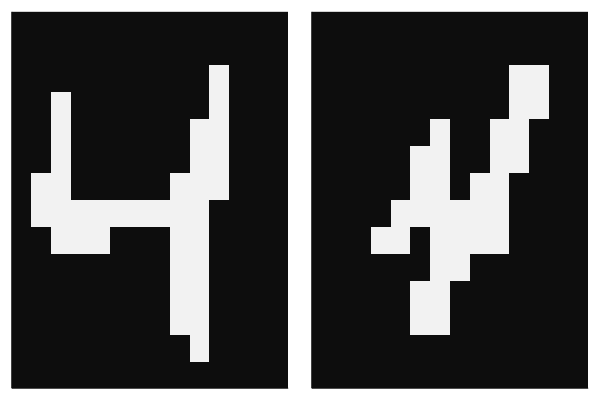

In [2]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 2 # Size of training dataset

digit = 4 # Digit to be learned
image_size = 28 # Size of image
compress_size = 14 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(train_set[c][1] .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? oh well it's not a big deal


In [3]:
using Yao
using FLOYao
using Flux

N = compress_size^2 #Number of qubits

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, identity))
    if !random
        for p in Flux.params(net)
            p .= (ones(size(p)) .* 0.08)
        end
    end
    return net
end

#d = NeuralNetwork() #Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 25, relu), Dense(25, 1, sigmoid)) #I have no clue what this looks like, and why does it have more parameters than expected

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
# function build_circuit(n::Int = N, nlayers::Int = layers)
#     circuit = chain(n) #Making the generator, which is a matchgate ansatz; this just uses Yao though? or does saying "using FLOYao" somehow change the implementation... Not really sure
#     for _ in 1:nlayers
#         for i in 1:N-1
#             push!(circuit, rot(kron(N, i => X, i+1 => X), 0.))
#         end
#         for i in 1:N
#             push!(circuit, put(N, i => Rz(0.)))
#         end
#     end
# end

#g = build_circuit()
#g = build_circuit() |> autodiff(:QC)

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, ones(nparams) ./ 100); 
dispatch!(g, :random);

Number of parameters in discriminator: 4951


Number of parameters in generator: 1955


μ: 84.0
σ: 4.242640687119285


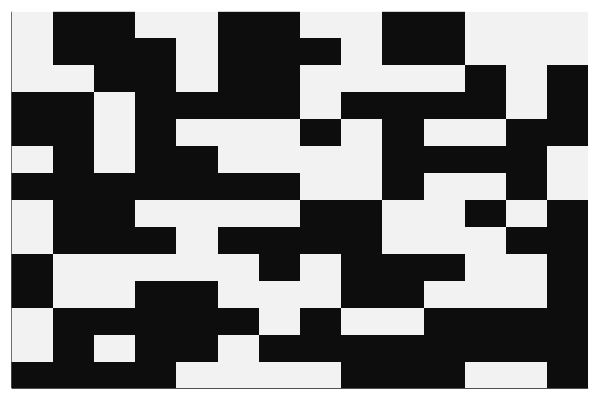

In [4]:
using FLOYao
using Random
using Distributions

#Not sure if there is a better pprior that we can choose, sometimes u get a lot of white or black bc variance is high (resolution: change var from sigma to sigma/10)
mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

ratio = rand(dist) / N
function pprior() #For each square, probability 1/ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [5]:
using Flux: train!

batch_size = train #Are you supposed to randomly pick batch_size data points at random each time if train is big? idk

println("START")

#g takes as input x = Int.(pprior()); FLOYao.product_state(x)
#d takes as input measure(x |> g)

function convertgd(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function run_circuit(z::MajoranaReg) #z is a MajoranaReg drawn from pprior (to guarantee matchgate speedup); this function applies D(G(z))
    g_output = z |> g |> measure
    d_input = convertgd(g_output)
    d_output = d_input |> d
    d_output |> first
end

measurement = run_circuit(pprior())
println("runcircuit: $measurement")

function run_d(x::BitMatrix) #this function applies D(x), where x is an element of data_train 
    d_output = x |> vec |> d
    d_output |> first
end

function gLoss(z::MajoranaReg) #z is sampled from pprior()
    -log(run_circuit(z))
end

function dLoss(m, real, fake) 
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

# Worry about this another day
# function gradient(op, reg::MajoranaReg) #does expect' (from FLOYao? or does it come from Yao?) use AD? Also idk what op should be
#     _, params_grad = expect'(op, reg => g)
# end
ε = 0.001
function finitediff_grad(z::MajoranaReg, eps = ε) #Returns the approximate gradient of G, using forward finite differences
    x = gLoss(z)
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss(z)
        grad[i] = (plus - x) / eps
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

# function finitediff_grad(z::MajoranaReg, eps = ε) #Returns the approximate gradient of G, using central finite differences
#     temp_params = parameters(g)
#     grad = zeros(nparameters(g))
#     temp = plus = minus = 0
#     for i in 1:nparameters(g)
#         temp = parameters(g)[i]
#         temp_params[i] = temp + eps
#         dispatch!(g, temp_params)
#         plus = gLoss(z)
#         temp_params[i] = temp - eps
#         dispatch!(g, temp_params)
#         minus = gLoss(z)
#         grad[i] = (plus - minus) / (2*eps)
#         temp_params[i] = temp
#         dispatch!(g, temp_params)
#     end
#     grad
# end

z = pprior()
@time finitediff_grad(z)

START


runcircuit: 0.3972045


 57.027934 seconds (58.36 M allocations: 31.953 GiB, 10.94% gc time, 0.26% compilation time)


1955-element Vector{Float64}:
  301.73856019973755
  -67.90769100189209
   11.342465877532959
   82.7208161354065
  -82.05372095108032
  -13.711154460906982
 -126.47849321365356
  172.66887426376343
    4.532217979431152
  -29.028475284576416
    ⋮
  113.83813619613647
  367.76143312454224
 -266.8091654777527
  137.28666305541992
   65.92881679534912
  108.23994874954224
  413.6926531791687
  -35.95900535583496
  502.12961435317993

In [6]:
g_lr = 0.01
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
epochs = 10

for i in 1:epochs
    real = []
    fake = []
    grads = []
    s = 0
    for m in 1:batch_size
        x = data_train[m] |> vec #What does vec do
        push!(real, Int.(x))
        z = pprior()
        push!(grads, finitediff_grad(z, ε))
        s += gLoss(z)
        push!(fake, convertgd(z |> g |> measure))
    end
    data = collect(zip(real, fake)) 
    println("data processing for iteration $i done")

    dispatch!(-, g, mean(grads)*g_lr) #Rule is - (as specified by first input), this is just gradient descent
    # _, gs = Flux.withgradient(m -> dLoss(m, real, fake), d)
    Flux.train!(dLoss, d, data, d_opt)

    println("Generator loss: ", s / batch_size)
    push!(gLoss_values, s / batch_size)

    s = 0
    for x in data
        s += dLoss(d, x[1], x[2])        
    end
    println("Discriminator loss: ", s / batch_size)
    push!(dLoss_values, s / batch_size)
end

#plot(gLoss_values)
x = 1:epochs
plot(x, [dLoss_values, gLoss_values], title="Loss Functions", label=["Discriminator Loss" "Generator Loss"], linewidth=3)

data processing for iteration 1 done


Generator loss: 0.62427545
Discriminator loss: 0.9207698


data processing for iteration 2 done
Generator loss: 0.8112359
Discriminator loss: 0.92325974


data processing for iteration 3 done
Generator loss: 1.0005593
Discriminator loss: 0.6652155


data processing for iteration 4 done
Generator loss: 1.2253401
Discriminator loss: 0.9435756


In [ ]:
#Testing the Discriminator

d_fake = run_circuit(pprior())
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d(data_train[index])
println("real data: $d_real") #Should print a number close to 1

In [ ]:
#Testing the Generator

using Random
nsamples = 16
samples = []
for i in 1:nsamples
    reg = pprior()
    s = reg |> g |> measure
    push!(samples, convertgd(s))
end
plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever